In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.trajectory_optimization import Solver, Functions, ProblemDefinition, constraint_geq, constraint_leq, unpack_res
from jax_control_algorithms.ui import manual_investigate, solve_and_plot, plot_iterations
from jax_control_algorithms.common import rk4

def make_time_vectors(X_opt, U_opt):
    # make time vectors
    t_X = jnp.linspace(0, X_opt.shape[0]-1, X_opt.shape[0])
    t_U = jnp.linspace(0, U_opt.shape[0]-1, U_opt.shape[0])
    
    return t_X, t_U

In [4]:
test_results = []

# Define the optimization problem: double-integrator dynamics

In [5]:
def problem_def_2integrator(n_steps, dt):
        
    def model(x, u, k, parameters):
        del k
        x_1, X_2,  = x[0], x[1]

        a,   = parameters['a'], 
        x_1_dot = jnp.squeeze(u) - a * x_1
        x_2_dot = x_1

        x_dot = jnp.array([
            x_1_dot, x_2_dot
        ])

        # cost + diff u
        J = parameters['wu'] * u**2
        
        return x_dot, J

    def f(x, u, k, parameters):
        x_dot, _ = model(x, u, k, parameters)
        return x_dot

    def g(x, u, k, parameters):
        
        x_dot, _ = model(x, u, k, parameters)
        return 

    def running_cost(x, u, k, parameters):
        
        x_dot, J  = model(x, u, k, parameters)
        J_normalized = J * 1.0 / n_steps
        
        return J_normalized
        
    def terminal_constraints(x_final, parameters):
        
        return jnp.array([
            x_final[0] - parameters['x_1_final'],           # != 0
            x_final[1] - parameters['x_2_final'],           # != 0
        ])
    
    def inequality_constraints(x, u, k, parameters):
        
        u = u[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( u, parameters['u_min'] ),
            constraint_leq( u, parameters['u_max'] ),
            
        ])
        
        # x_dot, P_transmission, P_yield, J, c_ineq = model(x, u, k, parameters)
        return c_ineq

    def initial_guess(x0, parameters):
                
        U_guess = jnp.zeros( (n_steps, 1) )
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], parameters['x_1_final'], n_steps),
            jnp.linspace( x0[1], parameters['x_2_final'], n_steps),
        )).T
        
        return { 'X_guess' : X_guess, 'U_guess' : U_guess }
    
    parameters = { 
        'a'             : 5.0, 
        'wu'            :  1.00,
        'u_min'         : -2.5,
        'u_max'         : 2.5,
        'x_1_final'     : 0.0,
        'x_2_final'     : 10.0,
    }
    
    x0 = jnp.array([ 0.0, 0.0 ])
    
    #
    f_dscr = rk4(f, dt)

    return ProblemDefinition(
        functions = Functions(
            f                      = f_dscr,
            initial_guess          = initial_guess,
            g                      = g,
            running_cost           = running_cost,
            terminal_constraints   = terminal_constraints,
            inequality_constraints = inequality_constraints,
        ),
        x0 = x0,
        parameters = parameters,
    )


def set_parameters_fn(solver, a, u_min, u_max):
        solver.problem_definition.parameters['a'] = a
        solver.problem_definition.parameters['u_min'] = u_min
        solver.problem_definition.parameters['u_max'] = u_max


In [6]:
def plot_2integrator(X_opt, U_opt, system_outputs, parameters):

    # prepare data
    u = U_opt[:,0]
    x_1, x_2 =  X_opt[:,0], X_opt[:,1]

    _ = system_outputs # unpack output variable (return of function g)

    # make time vectors
    t_X, t_U = make_time_vectors(X_opt, U_opt)
    
    # Create a figure and two subplots
    fig, (ax1, ax2, ) = plt.subplots(2, 1, sharex=True, figsize=(4, 6))

    ax1.plot( t_X, x_1, 'r', label='x_1')
    ax1.plot( t_X, x_2, 'k', label='x_2')
    ax1.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([parameters['x_2_final'], parameters['x_2_final']]), 'k:',
        label='x_2_final'
    )
    
    ax1.legend()
    ax1.set_ylabel('x_1 []')

    # 
    ax2.plot( t_U, u, 'k', label='u' )    
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([parameters['u_min'], parameters['u_min']]), ':k',
        label='u_min'
    )
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([parameters['u_max'], parameters['u_max']]), ':k',
        label='u_max'
    )
    
    ax2.legend()
    ax2.set_ylabel('u []')

    # Show the plot
    plt.show()

compiling optimizer...
👉 solving problem with n_horizon=50, n_states=2 n_inputs=1
🔄 it=0 	 (sub iter=103)	t=0 	eq_error/eq_tol=126560  gain=0.0 lambda=1.7323600482924109 	inside bounds: True
🔄 it=1 	 (sub iter=99)	t=1 	eq_error/eq_tol=107763  gain=1.174432068744008 lambda=1.7893927811858676 	inside bounds: True
🔄 it=2 	 (sub iter=105)	t=1 	eq_error/eq_tol=84226  gain=1.2794397639489083 lambda=1.8448023703016776 	inside bounds: True
🔄 it=3 	 (sub iter=112)	t=2 	eq_error/eq_tol=59394  gain=1.4180897312552108 lambda=1.8939759568384897 	inside bounds: True
🔄 it=4 	 (sub iter=116)	t=3 	eq_error/eq_tol=37819  gain=1.5704973307116938 lambda=1.9338016869283867 	inside bounds: True
🔄 it=5 	 (sub iter=121)	t=5 	eq_error/eq_tol=22131  gain=1.7088600474646911 lambda=1.9639259767347728 	inside bounds: True
🔄 it=6 	 (sub iter=123)	t=7 	eq_error/eq_tol=12154  gain=1.8209304511249051 lambda=1.9852507346735249 	inside bounds: True
🔄 it=7 	 (sub iter=135)	t=11 	eq_error/eq_tol=6380  gain=1.9049323806243

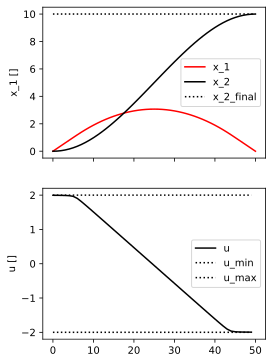

In [7]:
solver = Solver( partial(problem_def_2integrator, n_steps = 50, dt=0.1) )

set_parameters_fn(solver, a=0.0,  u_min=-2, u_max=2)
solver.verbose = True
X_opt, U_opt, system_outputs, res = solver.run()

# plot the results
plot_2integrator(X_opt, U_opt, system_outputs, solver.problem_definition.parameters)

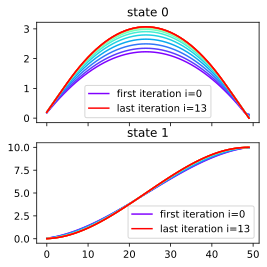

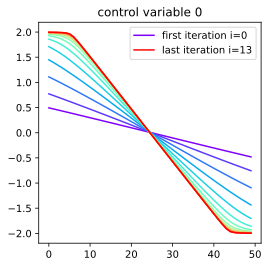

In [8]:
# show the convergence process
fig1, fig2 = plot_iterations(res, (4,4) )

# Build a UI to manually change parameters

In [10]:
sliders = {
        'a'     : widgets.FloatSlider(min=0.0,  max=1.0, step=0.01,  value=0.0,  description='a'),
        'u_min' : widgets.FloatSlider(min=-10,  max=0,   step=0.01,  value=-2,   description='u_min'),
        'u_max' : widgets.FloatSlider(min=0,    max=10,  step=0.01,  value=2,    description='u_max'),
}

solver = Solver( partial(problem_def_2integrator, n_steps = 50, dt=0.1) )

In [11]:
ui, output_box, print_output, plot_output = manual_investigate(solver, sliders, set_parameters_fn, plot_2integrator )
display(ui, plot_output, print_output)

GridBox(children=(FloatSlider(value=0.0, description='a', max=1.0, step=0.01), FloatSlider(value=-2.0, descrip…

Output()

Output()

In [12]:
test_results.append( ['double integrator', solver.success ] )

### Re-run with different initial conditions

In [13]:
solver.problem_definition.x0 = jnp.array( [0.1, 0.2] )
_ = solver.run()

👉 solving problem with n_horizon=50, n_states=2 n_inputs=1
🔄 it=0 	 (sub iter=102)	t=0 	eq_error/eq_tol=122244  gain=0.0 lambda=1.72774223155908 	inside bounds: True
🔄 it=1 	 (sub iter=101)	t=1 	eq_error/eq_tol=104091  gain=1.174387347908792 lambda=1.7842316859768328 	inside bounds: True
🔄 it=2 	 (sub iter=103)	t=1 	eq_error/eq_tol=81387  gain=1.2789754560747137 lambda=1.8390591833556362 	inside bounds: True
🔄 it=3 	 (sub iter=113)	t=2 	eq_error/eq_tol=57428  gain=1.4171968054969755 lambda=1.887609957770989 	inside bounds: True
🔄 it=4 	 (sub iter=117)	t=3 	eq_error/eq_tol=36552  gain=1.5711112834541572 lambda=1.9264973036694084 	inside bounds: True
🔄 it=5 	 (sub iter=122)	t=5 	eq_error/eq_tol=21337  gain=1.7130896375511475 lambda=1.9549783182057725 	inside bounds: True
🔄 it=6 	 (sub iter=122)	t=7 	eq_error/eq_tol=11686  gain=1.8258941235010082 lambda=1.9741493073681207 	inside bounds: True
🔄 it=7 	 (sub iter=126)	t=11 	eq_error/eq_tol=6129  gain=1.9067506077840948 lambda=1.985611805149

# Verify

In [14]:
def verify_test_results(test_results):
    for r in test_results:
        if not r[1]:
            raise BaseException('Test ' + r[0] + ' failed')
            
verify_test_results(test_results)